In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip uninstall sklearn -y
!pip install --upgrade sklearn
!pip install scikit-learn==0.23.2 --user

In [ ]:
import sklearn
sklearn.__version__

In [ ]:
from pycaret.utils import enable_colab
enable_colab()

In [ ]:
!pip install pycaret

In [ ]:
pip install markupsafe==2.0.1

In [ ]:
from pycaret.classification import *

In [ ]:
!pip install bayesian-optimization
!pip install scikit-optimize

## Library

In [3]:
# basic
import numpy as np
import pandas as pd
import os
import glob
import warnings
import random
warnings.filterwarnings('ignore')

# plot
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

# models
import time
import datetime
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *
from sklearn.model_selection import StratifiedKFold, KFold

from pycaret.classification import *

from xgboost import XGBClassifier

from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV
import imblearn

In [4]:
# define Seaborn color palette to use
colors = sns.color_palette("crest", 8)
cmap_colors = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

# define the fig size of all figures
plt.rcParams["figure.figsize"] = (10,6)
# the directory to unzip the data in
path = '/content/drive/MyDrive/Colab Notebooks/kurly/data/'

# Converting the days and hours from numbers to their interpretable form
days_of_week = {0: 'Saturday', 
                1: 'Sunday', 
                2: 'Monday',
                3: 'Tuesday',
                4: 'Wednesday',
                5: 'Thursday',
                6: 'Friday'}
                
hour_nums = list(range(24))
hours_of_day = {hour_num:datetime.time(hour_num).strftime("%I:00 %p") for hour_num in hour_nums}

In [5]:
def reduce_mem_usage(train_data):
    start_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in train_data.columns:
        col_type = train_data[col].dtype
        
        if col_type not in [object, 'category']:
            c_min = train_data[col].min()
            c_max = train_data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_data[col] = train_data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_data[col] = train_data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_data[col] = train_data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_data[col] = train_data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train_data[col] = train_data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_data[col] = train_data[col].astype(np.float32)
                else:
                    train_data[col] = train_data[col].astype(np.float64)
        else:
            train_data[col] = train_data[col].astype('category')
    end_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return train_data

# Annotate text on graph
def annotate_text(p, append_to_text='%'):
    for p in ax.patches:
        txt = str(p.get_height().round(2)) + append_to_text
        txt_x = p.get_x() + p.get_width()/2.
        txt_y = 0.92*p.get_height()
        ax.text(txt_x,txt_y,txt, fontsize=20, color='#004235', ha='center', va='bottom')

## File load

In [6]:
aisles = pd.read_csv(path + 'aisles.csv')
departments = pd.read_csv(path + 'departments.csv')
order_products_prior = pd.read_csv(path + 'order_products__prior.csv')
order_products_train = pd.read_csv(path + 'order_products__train.csv')
orders = pd.read_csv(path + 'orders.csv')
products = pd.read_csv(path + 'products.csv')

# Replacing numbers with their corresponding hour representation
orders['order_hour_of_day'] = orders['order_hour_of_day'].replace(to_replace=hours_of_day, value=None)
orders['order_hour_of_day'] = pd.Categorical(orders['order_hour_of_day'], 
                                             ordered=True, 
                                             categories=list(hours_of_day.values()))
# Replacing numbers with their corresponding day of week
# Define the categories of days of week sorted normally from Saturday to Friday
orders['order_dow'] = orders['order_dow'].replace(to_replace=days_of_week, value=None)
orders['order_dow'] = pd.Categorical(orders['order_dow'], 
                                     ordered=True, 
                                     categories=list(days_of_week.values()))

In [7]:
print('Shape of order_products_train table: ', order_products_train.shape)
order_products_train.head(10)

Shape of order_products_train table:  (1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1
8,36,39612,1,0
9,36,19660,2,1


In [8]:
print('shape : ', order_products_prior.shape)
order_products_prior.head(10)

shape :  (32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


In [9]:
print('Shape of products table: ', products.shape)
print('Uniques products', products['product_name'].nunique())
products.head(20)

Shape of products table:  (49688, 4)
Uniques products 49688


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
5,6,Dry Nose Oil,11,11
6,7,Pure Coconut Water With Orange,98,7
7,8,Cut Russet Potatoes Steam N' Mash,116,1
8,9,Light Strawberry Blueberry Yogurt,120,16
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7


In [10]:
organic = products['product_name'].str.contains('Organic')
products['is_organic'] = organic
products.iloc[20:30].head()

,product_id,product_name,aisle_id,department_id,is_organic
20,21,Small & Medium Dental Dog Treats,40,8,False
21,22,Fresh Breath Oral Rinse Mild Mint,20,11,False
22,23,Organic Turkey Burgers,49,12,True
23,24,Tri-Vi-Sol® Vitamins A-C-and D Supplement Drop...,47,11,False
24,25,Salted Caramel Lean Protein & Fiber Bar,3,19,False


In [11]:
print('Shape of departments table: ', departments.shape)
departments.head(departments.shape[0])

Shape of departments table:  (21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [12]:
print('Shape of aisles table: ', aisles.shape)
aisles.head(10)

Shape of aisles table:  (134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
5,6,other
6,7,packaged meat
7,8,bakery desserts
8,9,pasta sauce
9,10,kitchen supplies


In [13]:
print('Shape of Orders table: ', orders.shape)
orders.head(12)

Shape of Orders table:  (3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,Monday,08:00 AM,NaN
1,2398795,1,prior,2,Tuesday,07:00 AM,15.0
2,473747,1,prior,3,Tuesday,12:00 PM,21.0
3,2254736,1,prior,4,Wednesday,07:00 AM,29.0
4,431534,1,prior,5,Wednesday,03:00 PM,28.0
5,3367565,1,prior,6,Monday,07:00 AM,19.0
6,550135,1,prior,7,Sunday,09:00 AM,20.0
7,3108588,1,prior,8,Sunday,02:00 PM,14.0
8,2295261,1,prior,9,Sunday,04:00 PM,0.0
9,2550362,1,prior,10,Wednesday,08:00 AM,30.0


## Preprocess

In [14]:
# Merging the Prior and train order_products
order_products = pd.concat([order_products_train, order_products_prior])
order_products = order_products.merge(products, on='product_id', how='left').merge(orders, on='order_id', how='left').merge(departments, on='department_id').merge(aisles, on='aisle_id')

# Count of total orders
total_orders = order_products['order_id'].nunique()
print('Count of total orders: ', total_orders)

print('Merging products, order_products, and orders tables...')

order_products.head()

Count of total orders:  3346083
Merging products, order_products, and orders tables...


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,is_organic,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,aisle
0,1,49302,1,1,Bulgarian Yogurt,120,16,False,112108,train,4,Wednesday,10:00 AM,9.0,dairy eggs,yogurt
1,98,43654,3,1,Whole Milk Greek Blended Vanilla Bean Yogurt,120,16,False,56463,train,41,Tuesday,08:00 AM,14.0,dairy eggs,yogurt
2,170,8153,6,0,Plain Non-Fat Greek Yogurt,120,16,False,182389,train,7,Saturday,01:00 PM,14.0,dairy eggs,yogurt
3,631,9203,13,1,Dairy Free Coconut Milk Raspberry Yogurt Alter...,120,16,False,184099,train,7,Tuesday,09:00 AM,30.0,dairy eggs,yogurt
4,631,15842,14,1,Dairy Free Coconut Milk Yogurt Alternative,120,16,False,184099,train,7,Tuesday,09:00 AM,30.0,dairy eggs,yogurt


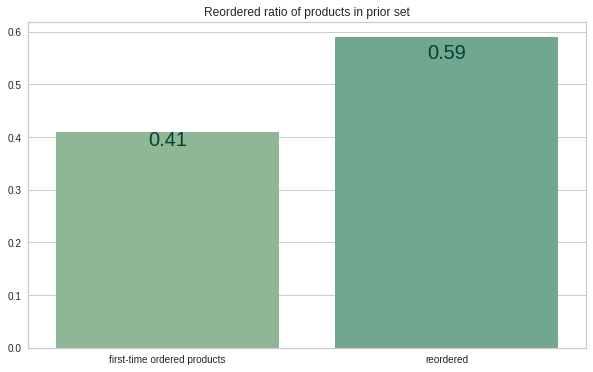

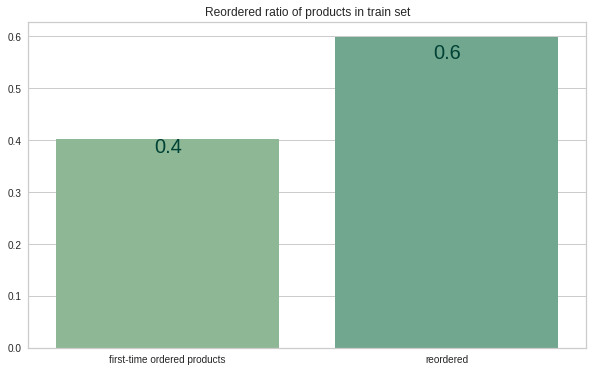

In [15]:
total_prod_count = order_products_prior.shape[0]
reorder_ratio = order_products_prior['reordered'].value_counts()/total_prod_count
ax = sns.barplot(x=reorder_ratio.index, y=reorder_ratio.values, palette=colors)
ax.set_xticklabels(['first-time ordered products', 'reordered'])
annotate_text(ax, append_to_text='')
plt.title('Reordered ratio of products in prior set')
plt.show()

total_prod_count = order_products_train.shape[0]
reorder_ratio = order_products_train['reordered'].value_counts()/total_prod_count
ax = sns.barplot(x=reorder_ratio.index, y=reorder_ratio.values, palette=colors)
ax.set_xticklabels(['first-time ordered products', 'reordered'])
annotate_text(ax, append_to_text='')
plt.title('Reordered ratio of products in train set')
plt.show()

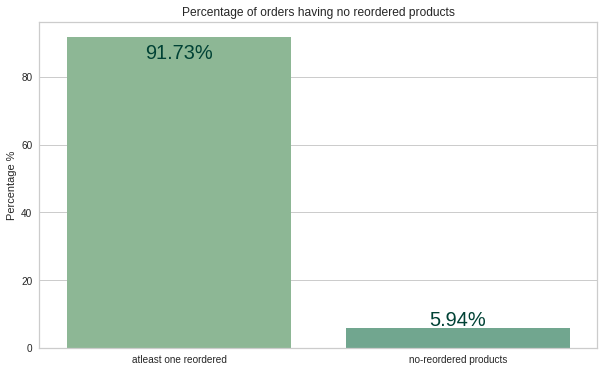

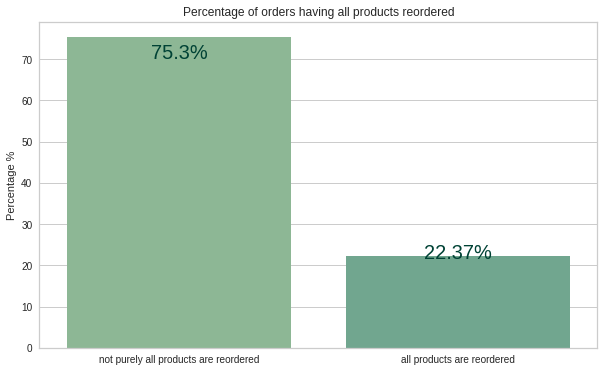

,order_id,reordered_ratio,order_number,no_reordered,all_reordered
0,1,0.500000,4,False,False
1,2,0.666667,3,False,False
2,3,1.000000,16,False,True
3,4,0.923077,36,False,False
4,5,0.807692,42,False,False


In [16]:
groupeddf = order_products.groupby(['order_id']).agg({'reordered':'mean', 'order_number':'first'}).reset_index().rename(columns={'reordered':'reordered_ratio'})
groupeddf['no_reordered'] = groupeddf['reordered_ratio'] == 0
groupeddf['all_reordered'] = groupeddf['reordered_ratio'] == 1.0

# Count of non-first orders
non_first_orders_Mask = orders.order_number != 1
non_first_orders_count = np.sum(non_first_orders_Mask)

# Ratio of non-first orders containing no previously ordered products vs containing at least one previously ordered products
groupeddf = groupeddf[groupeddf.order_number != 1]
groupeddf['no_reordered'] = groupeddf['reordered_ratio'] == 0
no_reordered_count = groupeddf['no_reordered'].value_counts()/non_first_orders_count * 100
ax = sns.barplot(x=no_reordered_count.index, y=no_reordered_count.values, palette=colors)
annotate_text(ax)
ax.set_xticklabels(['atleast one reordered', 'no-reordered products'])
plt.title('Percentage of orders having no reordered products')
plt.ylabel('Percentage %')
plt.show()

# Ratio of non-first orders where their products were all previously purchased
groupeddf['all_reordered'] = groupeddf['reordered_ratio'] == 1.0
all_reordered_count = groupeddf['all_reordered'].value_counts()/non_first_orders_count * 100
ax = sns.barplot(x=all_reordered_count.index, y=all_reordered_count.values, palette=colors)
annotate_text(ax)
ax.set_xticklabels(['not purely all products are reordered', 'all products are reordered'])
plt.title('Percentage of orders having all products reordered')
plt.ylabel('Percentage %')
plt.show()

groupeddf.head()

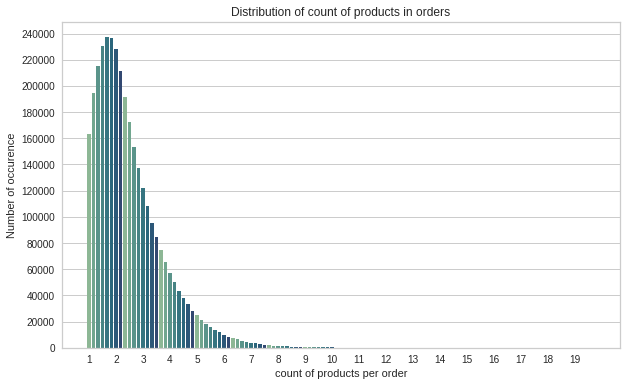

In [17]:
# Ploting a histogram for the # of products in an order
count_of_products = order_products.groupby(['order_id'], as_index=False)['product_id'].count()
count_of_products['count_of_products'] = count_of_products['product_id']
sns.countplot(x='count_of_products', data=count_of_products, palette=colors)
plt.xlabel('count of products per order')
plt.ylabel('Number of occurence')
plt.title('Distribution of count of products in orders')
plt.locator_params(nbins=20)
plt.show()

del count_of_products

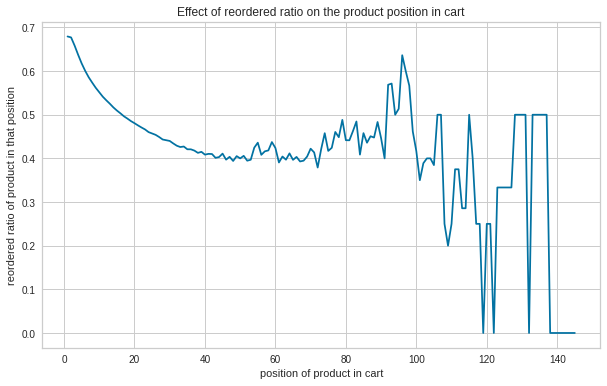

In [18]:
# Relation between the order number and the reorder ratio of that order

# Relation between the add to cart postiion and the reorder ratio of that product
groupeddf = order_products.groupby(['add_to_cart_order']).agg({'reordered':'mean'}).rename(columns={'reordered':'reordered_ratio'}).reset_index()
sns.lineplot(x=groupeddf['add_to_cart_order'], y=groupeddf['reordered_ratio'], palette=colors)
plt.title('Effect of reordered ratio on the product position in cart')
plt.xlabel('position of product in cart')
plt.ylabel('reordered ratio of product in that position')
plt.show()

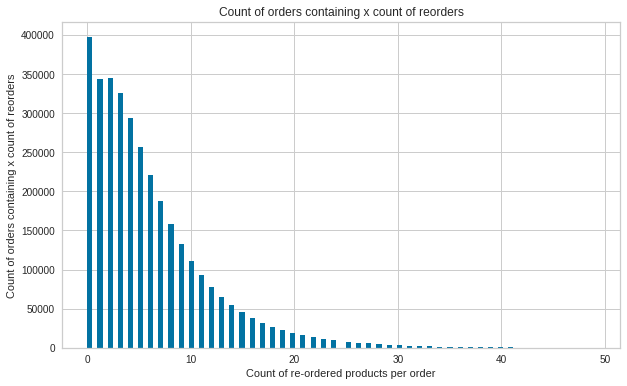

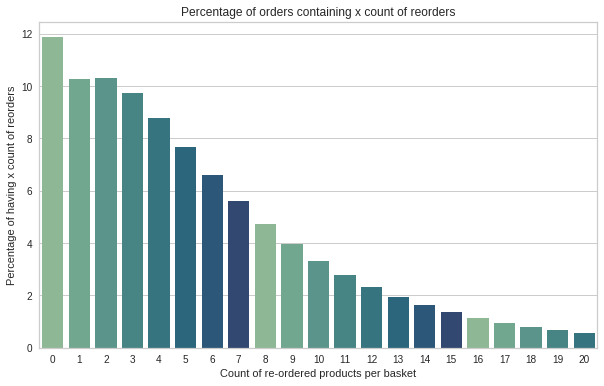

In [19]:
# Ploting a histogram for the # of reordered products in an order
count_of_reordered_products = order_products.groupby(['order_id'], as_index=False)['reordered'].sum()
count_of_reordered_products['count_of_reordered_products'] = count_of_reordered_products['reordered']
less_than_50_reordered_products = count_of_reordered_products[count_of_reordered_products['count_of_reordered_products']<50]
less_than_50_reordered_products['count_of_reordered_products'].hist(bins=100)
plt.ylabel('Count of orders containing x count of reorders')
plt.xlabel('Count of re-ordered products per order')
plt.title('Count of orders containing x count of reorders')

plt.show()

# Percentage of orders having x count_of_reordered_products
reordered_products_count_histogram = count_of_reordered_products.groupby(['count_of_reordered_products'], as_index=False).count()
reordered_products_count_histogram['count_of_orders'] = reordered_products_count_histogram['reordered']
reordered_products_count_histogram['percentage_of_this_reordered_count'] = (reordered_products_count_histogram['count_of_orders']/total_orders) * 100
reordered_products_count_histogram = reordered_products_count_histogram[['count_of_reordered_products','count_of_orders','percentage_of_this_reordered_count']]
# Filter reorders counts occuring by prob less than 0.5% 
mask = reordered_products_count_histogram['percentage_of_this_reordered_count'] > 0.5
reordered_products_count_histogram = reordered_products_count_histogram[mask].sort_values(by=['percentage_of_this_reordered_count'], ascending=False)

sns.barplot(x=reordered_products_count_histogram['count_of_reordered_products'], y=reordered_products_count_histogram['percentage_of_this_reordered_count'].values, palette=colors)
plt.ylabel('Percentage of having x count of reorders')
plt.xlabel('Count of re-ordered products per basket')
plt.title('Percentage of orders containing x count of reorders')
plt.show()

reordered_products_count_histogram.head()

del less_than_50_reordered_products, count_of_reordered_products, reordered_products_count_histogram, mask

* Users always order previously ordered products:
* Count of users: 685

In [ ]:
# Getting list of user ids, who always reorder products from their first order.
non_first_orders_mask = order_products['order_number'] != 1
groupeddf = order_products[non_first_orders_mask].groupby(['user_id']).agg({'reordered':'mean', 'order_number':'count'}).rename(columns={'reordered':'reordered_ratio'})
mask = groupeddf['reordered_ratio'] == 1
always_reorder_users_id = groupeddf[mask].index.to_list()
#print('Count of users who always order the same products every time:', len(always_reorder_users_id))

# getting the orders of the a random user
rand_indx = random.randint(0,len(always_reorder_users_id))
rand_user_id = always_reorder_users_id[rand_indx]
user_mask = orders['user_id'] == rand_user_id
user_orders = orders[user_mask]['order_id'].to_list()
# print(f'Orders of user {rand_user_id}:')
# print(f'Count of his orders: {len(user_orders)}')
# for order_id in user_orders:
#     print(f'Order number{order_id}:')
#     print(order_products[order_products['order_id'] == order_id]['product_name'].to_list())
#     print('--------------')
del groupeddf, mask, always_reorder_users_id

## histogram

In [ ]:
# Histogram for order day of week
sns.histplot(data=orders, x='order_dow', palette=colors, bins=7)
plt.xlabel('order_dow')
plt.ylabel('Count of orders')
plt.title('요일별 구매 빈도')
plt.xticks(rotation= 45)
plt.show()

# Histogram for order hour of day
sns.histplot(data=orders, x='order_hour_of_day', palette=colors, bins=24)
plt.xlabel('order hour of day')
plt.xticks(rotation= 45)
plt.ylabel('Count of orders')
plt.title('시간별 구매 빈도')
plt.show()

# Histogram for days passed before last order
sns.histplot(data=orders, x='days_since_prior_order', palette=colors, bins=30)
plt.xlabel('days since prior order')
plt.ylabel('Count of orders')
plt.title('재구매까지의 소요일')
plt.show()